In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
train = pd.read_csv('/content/drive/My Drive/train.csv', index_col=0)
test = pd.read_csv('/content/drive/My Drive/test.csv', index_col=0)
sample_submission = pd.read_csv('/content/drive/My Drive/sample_submission.csv', index_col=0)

Using TensorFlow backend.


In [0]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
    
def to_number(x, dic):
    return dic[x]

train['type_num'] = train['type'].apply(lambda x: to_number(x, column_number))

In [0]:
X_train = train.drop(columns=['type', 'type_num'], axis=1)
y_train = train['type_num']
X_test = test

In [4]:
X_train.describe()

,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
count,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,1.999910e+05,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000,199991.000000
mean,360.830152,-6.750146e+00,18.675373,18.401235,18.043495,17.663526,1.084986e+01,19.072693,19.134483,18.183331,18.000882,21.837903,18.454136,18.481525,17.686617,17.699207,20.110991,18.544375,18.181544,17.692395,17.189281
std,225.305890,1.187678e+04,155.423024,127.128078,116.622194,123.735298,4.172116e+03,749.256162,90.049058,122.378972,145.862346,789.472333,154.376277,97.240448,145.730872,142.691880,122.299062,161.728183,133.984475,131.183416,133.685138
min,1.000000,-5.310802e+06,-40022.466071,-27184.795793,-26566.310827,-24878.828280,-1.864766e+06,-215882.917191,-21802.656144,-20208.516262,-26505.602101,-24463.431833,-25958.752324,-23948.588523,-40438.184078,-30070.729379,-26236.578659,-36902.402336,-36439.638493,-38969.416822,-26050.710196
25%,174.000000,1.965259e+01,18.701180,18.048572,17.747663,17.425523,1.994040e+01,18.902851,18.259352,17.903615,17.606148,19.247795,18.113933,17.479794,17.050294,16.804705,19.266214,18.076120,17.423425,16.977671,16.705774
50%,349.000000,2.087136e+01,19.904235,19.454492,19.043895,18.611799,2.104910e+01,20.069038,19.631419,19.188763,18.710967,20.366848,19.586559,19.182789,18.693370,18.174592,20.406840,19.547674,19.143156,18.641756,18.100997
75%,526.000000,2.216043e+01,21.150297,20.515936,20.073528,19.883760,2.233754e+01,21.385830,20.773911,20.331419,20.133179,21.797480,21.004397,20.457491,20.019112,19.807652,21.992898,20.962386,20.408140,19.968846,19.819554
max,1000.000000,1.877392e+04,3538.984910,3048.110913,4835.218639,9823.740407,4.870154e+03,248077.513380,12084.735440,8059.638535,18358.921741,298771.019041,12139.815877,7003.136546,9772.190537,17403.789263,14488.251976,10582.058590,12237.951703,4062.499371,7420.534172


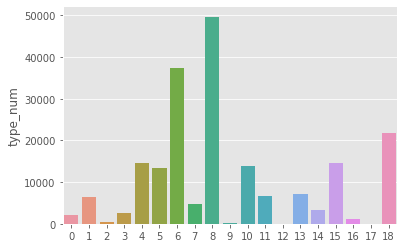

In [5]:
import seaborn as sns
sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().sort_values()[::-1])

In [6]:
y_train.value_counts()[::-1]
#12 17 9 2   sparse labels

12       13
17       61
9       127
2       500
16     1154
0      2160
3      2562
14     3257
7      4654
1      6506
11     6580
13     7132
5     13500
10    13750
4     14618
15    14630
18    21760
6     37347
8     49680
Name: type_num, dtype: int64

In [0]:
def show_boxplot(X,y):
  fig,axes=plt.subplots(7,3,figsize=(25,25))
  for i,ax in enumerate(axes.ravel()):
    sns.boxplot(x=y, y=X.iloc[:,i],ax=ax)
    plt.ylim(X.iloc[:,i].min()-100,X.iloc[:,i].max()+100)


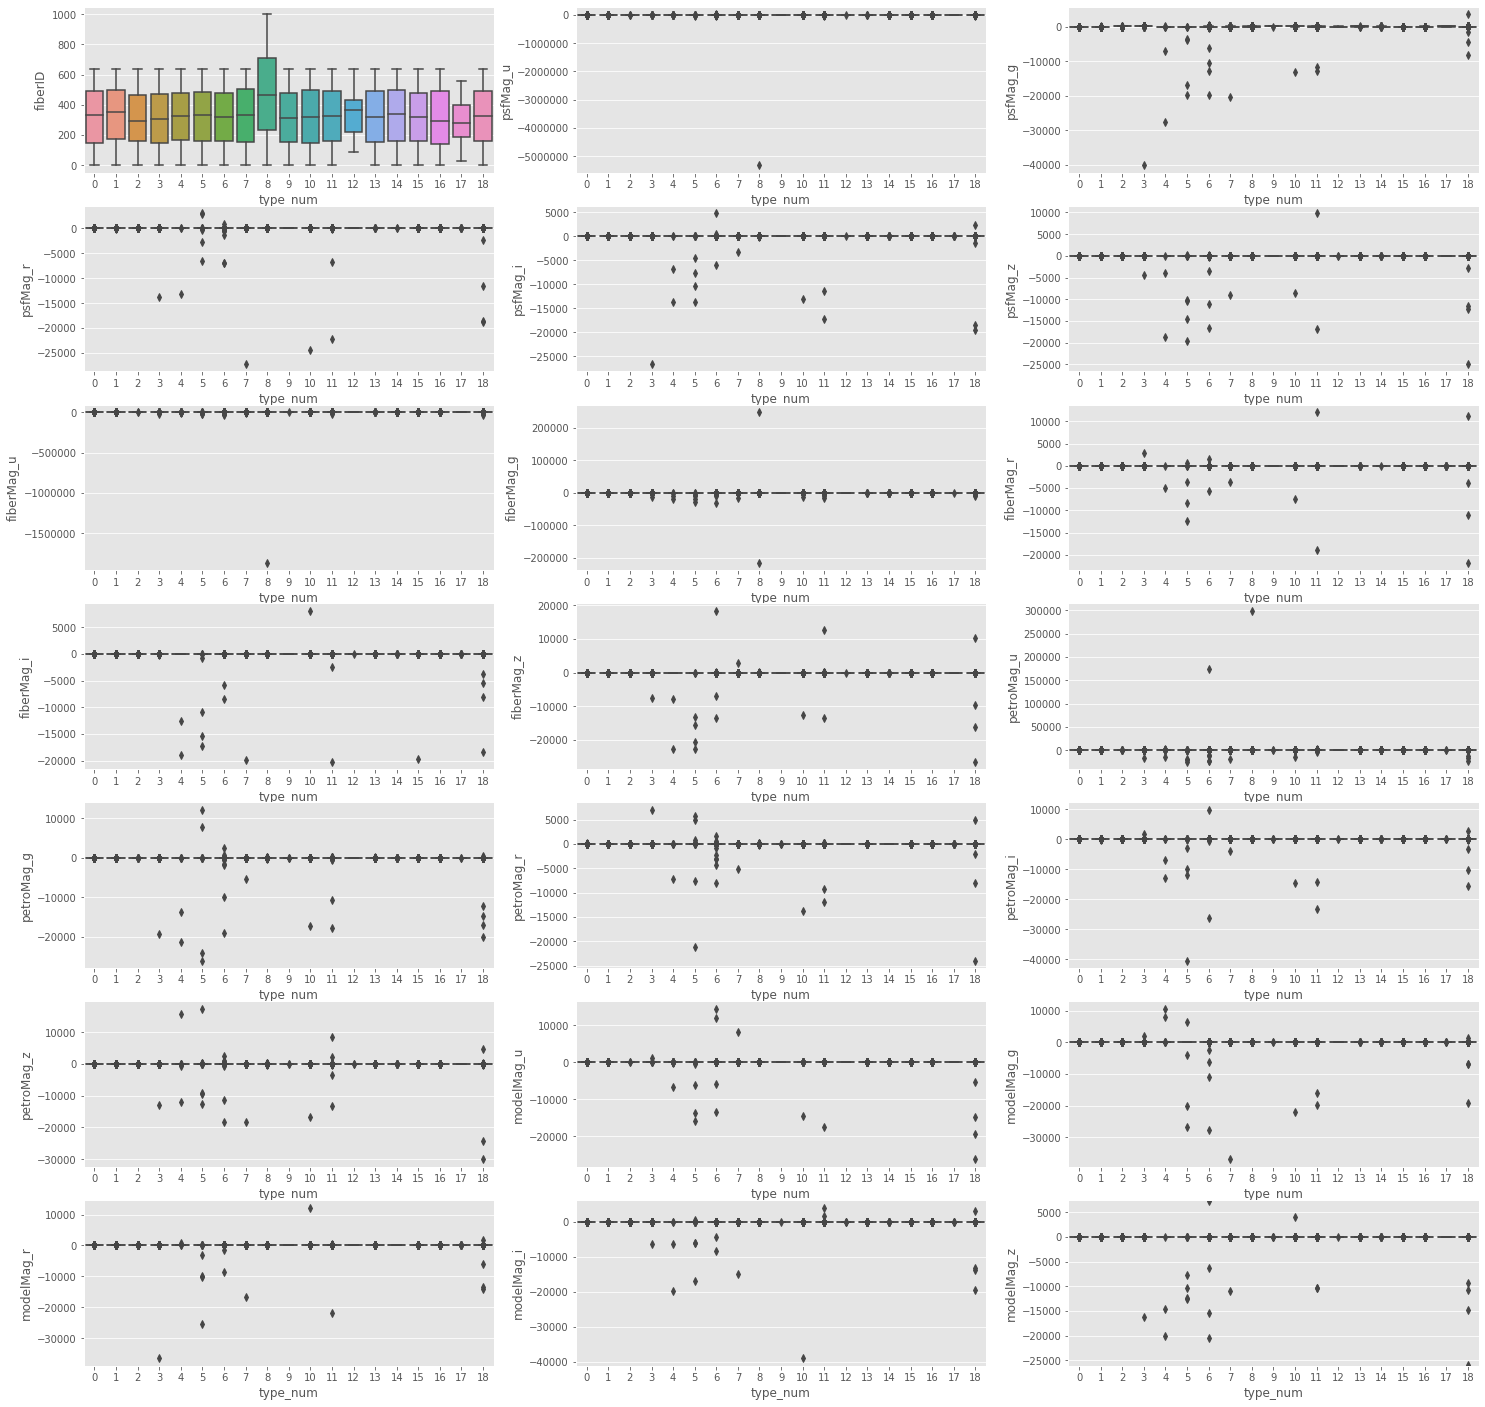

In [8]:
show_boxplot(X_train,y_train)

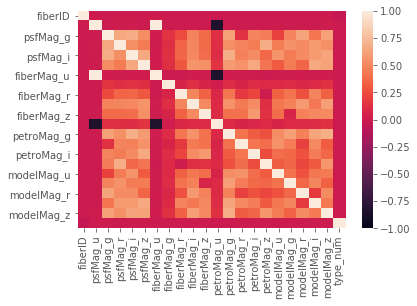

In [9]:

sns.heatmap(data=train.iloc[:,1:].corr(),vmin=-1,vmax=1)

In [0]:
from sklearn.model_selection import train_test_split

X_train_small,X_val,y_train_small,y_val=train_test_split(X_train,y_train,stratify=y_train,random_state=301)

In [0]:
#Outlier 

def find_outlier(data=None,weight=10):
  q_25=np.percentile(data.values,25,axis=0)
  q_75=np.percentile(data.values,75,axis=0)

  iqr=q_75-q_25
  w_iqr=iqr*weight
  lowest=q_25-w_iqr
  highest=q_75+w_iqr

  outlier_removed_index=data[(data>lowest) & (data<highest)].dropna().index
  return outlier_removed_index

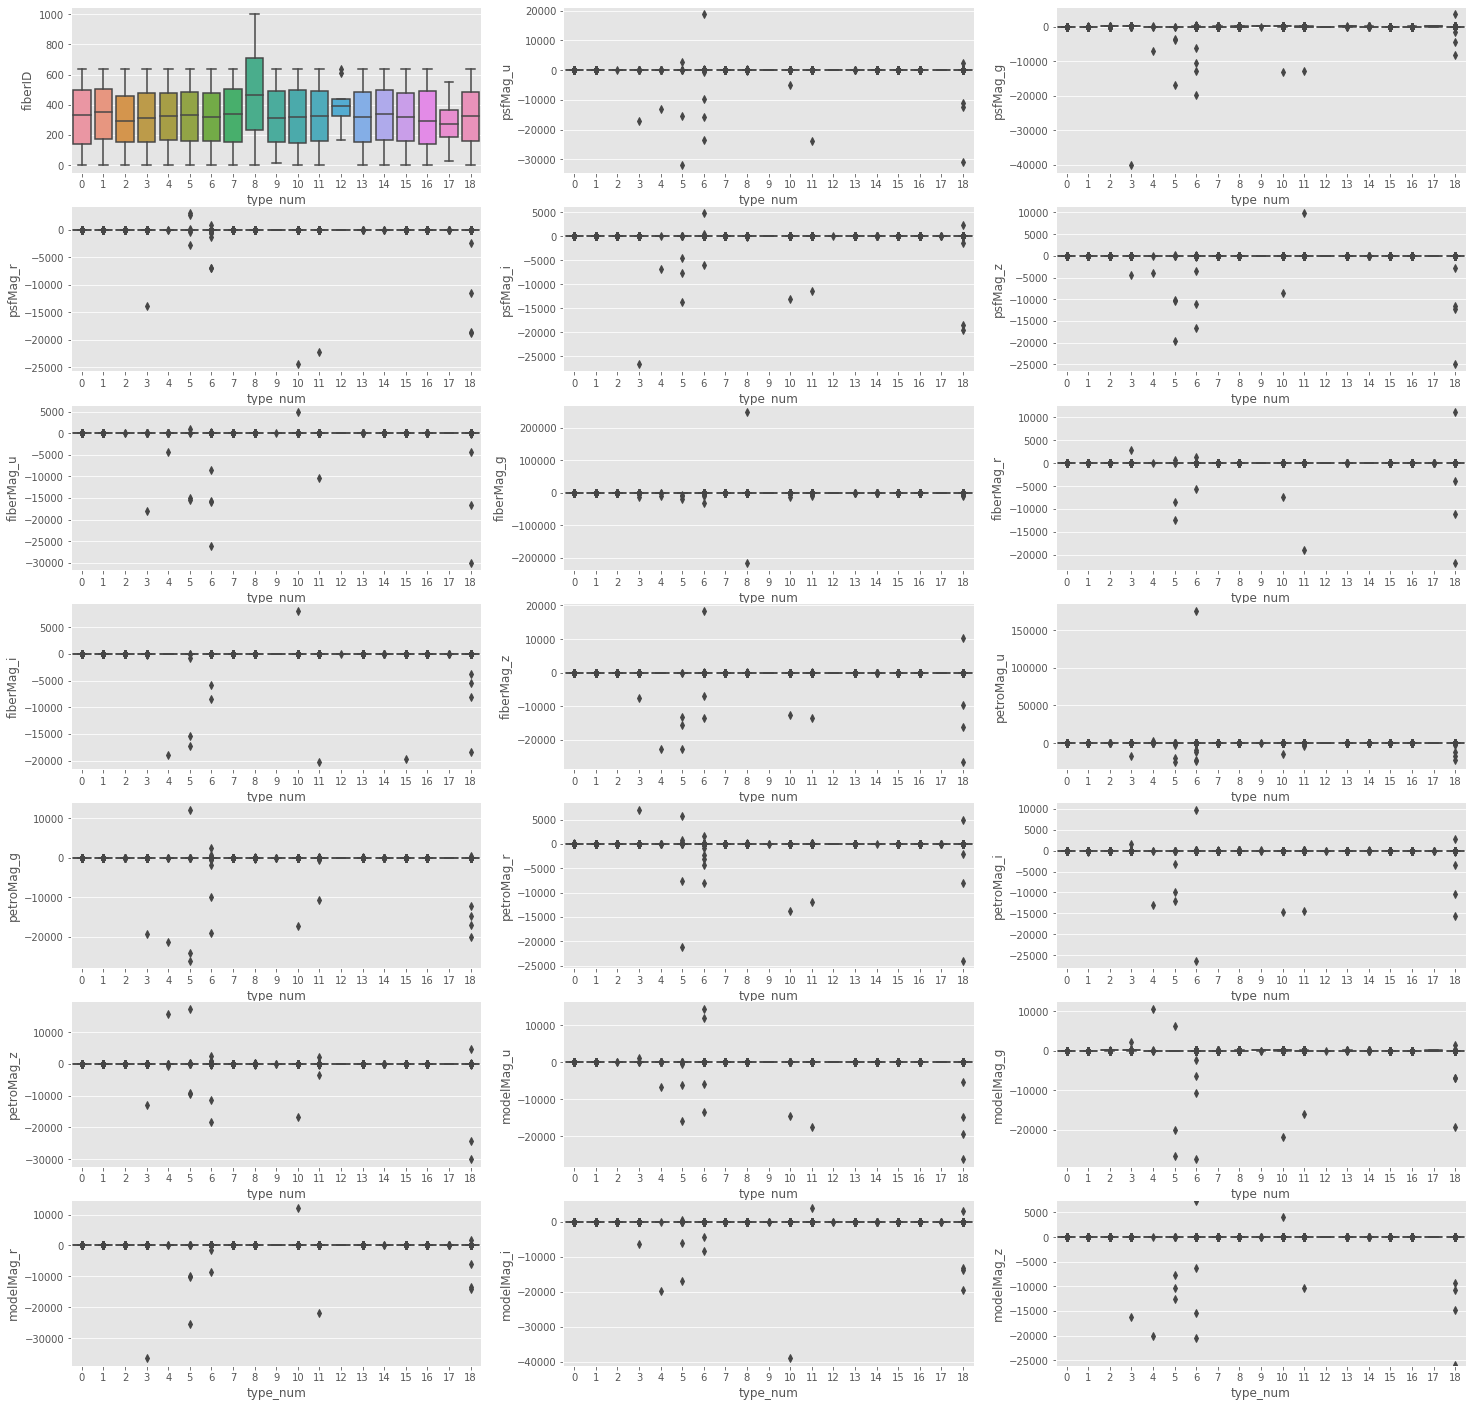

In [12]:
show_boxplot(X_train_small,y_train_small)

In [13]:
print(X_train_small.shape)
outlier_removed_index=find_outlier(X_train_small,10)
X_train_small_out=X_train_small.loc[outlier_removed_index]
y_train_small_out=y_train_small[outlier_removed_index]
print(X_train_small_out.shape,y_train_small_out.shape)

(149993, 21)
(149785, 21) (149785,)


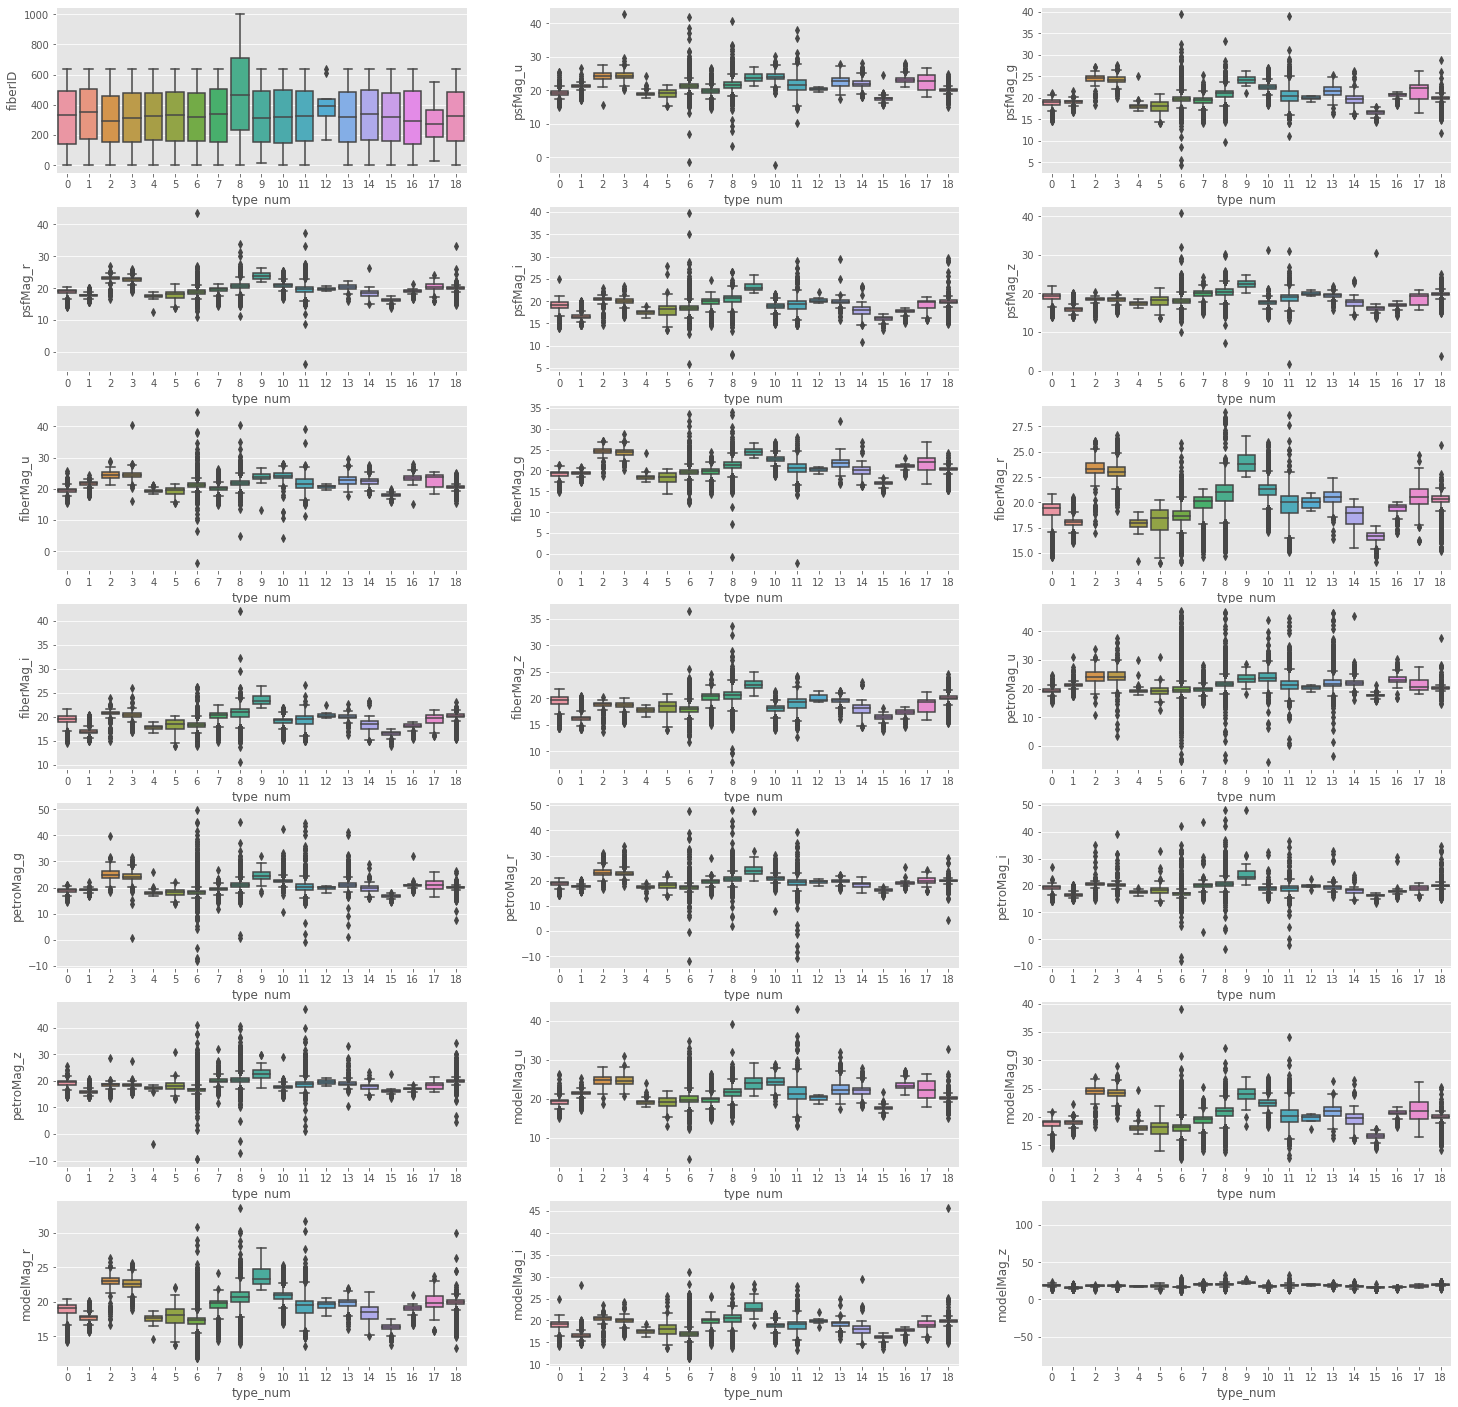

In [14]:
show_boxplot(X_train_small_out,y_train_small_out)

In [15]:
q_25=np.percentile(X_train_small.values,25,axis=0)
q_75=np.percentile(X_train_small.values,75,axis=0)
weight=10
iqr=q_75-q_25
w_iqr=iqr*weight
lowest=q_25-w_iqr
highest=q_75+w_iqr

outlier_removed_index=X_val[(X_val>lowest) & (X_val<highest)].dropna().index
X_val_out=X_val.loc[outlier_removed_index]
y_val_out=y_val[outlier_removed_index]
print(X_val.shape,X_val_out.shape,y_val_out.shape)

(49998, 21) (49918, 21) (49918,)


In [0]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train_small_out)
X_train_scaled=scaler.transform(X_train_small_out)
X_val_scaled=scaler.transform(X_val_out)

In [17]:
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
model=keras.models.Sequential()
model.add(layers.Dense(256,activation='relu',input_shape=(21,)))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(19,activation='softmax'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5632      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 19)                4883      
Total params: 142,099
Trainable params: 142,099
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0015),metrics=['acc'])
history=model.fit(X_train_scaled,y_train_small_out,epochs=45,batch_size=32,validation_data=(X_val_scaled,y_val_out))

Train on 149785 samples, validate on 49918 samples
Epoch 1/45
149785/149785 [==============================] - 21s 139us/step - loss: 0.5429 - acc: 0.8232 - val_loss: 0.4734 - val_acc: 0.8429
Epoch 2/45
149785/149785 [==============================] - 19s 126us/step - loss: 0.4450 - acc: 0.8502 - val_loss: 0.4600 - val_acc: 0.8430
Epoch 3/45
149785/149785 [==============================] - 18s 122us/step - loss: 0.4225 - acc: 0.8569 - val_loss: 0.4131 - val_acc: 0.8560
Epoch 4/45
149785/149785 [==============================] - 20s 131us/step - loss: 0.4083 - acc: 0.8612 - val_loss: 0.3998 - val_acc: 0.8646
Epoch 5/45
149785/149785 [==============================] - 19s 125us/step - loss: 0.4011 - acc: 0.8629 - val_loss: 0.4253 - val_acc: 0.8602
Epoch 6/45
149785/149785 [==============================] - 19s 128us/step - loss: 0.3945 - acc: 0.8654 - val_loss: 0.4140 - val_acc: 0.8564
Epoch 7/45
149785/149785 [==============================] - 20s 132us/step - loss: 0.3888 - acc: 0.8671

In [0]:
def plot_loss(history):

  fig,axes=plt.subplots(1,2,figsize=(14,6))
  train_categorical_crossentropy=history.history['loss'] 
  validation_categorical_crossentropy=history.history['val_loss']
  xlimit=range(1,len(validation_categorical_crossentropy)+1)
  axes[0].plot(xlimit,train_categorical_crossentropy,'r',label='Training Categorical CrossEntropy')
  axes[0].plot(xlimit,validation_categorical_crossentropy,'b',label='Validation Categorical CrossEntropy')
  axes[0].set_title('Losses Graph')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()
  

  train_acc=history.history['acc'] 
  validation_acc=history.history['val_acc']
  xlimit=range(1,len(validation_acc)+1)
  axes[1].plot(xlimit,train_acc,'r',label='Training  acc')
  axes[1].plot(xlimit,validation_acc,'b',label='Validation  acc')
  axes[1].set_title('Acc Graph')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Acc')
  axes[1].legend()
 
  print('batch_size :', history.params['batch_size'])

batch_size : 32


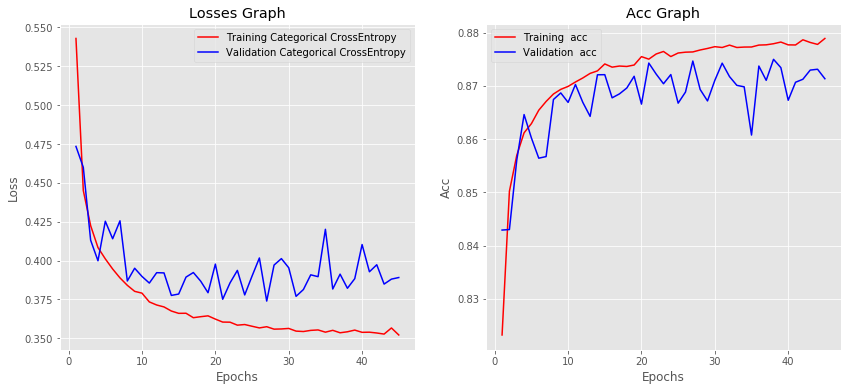

In [0]:
plot_loss(history)
#Adam (lr=0.0015)

batch_size : 32


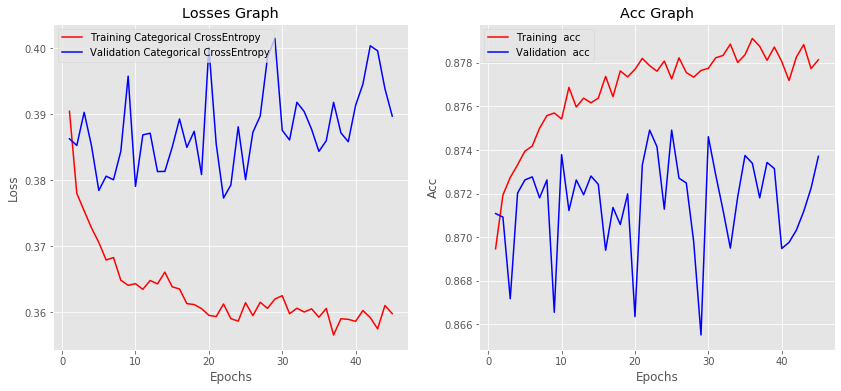

In [0]:
plot_loss(history)
#Adam (lr=0.0015)
#256 256 256 19

batch_size : 64


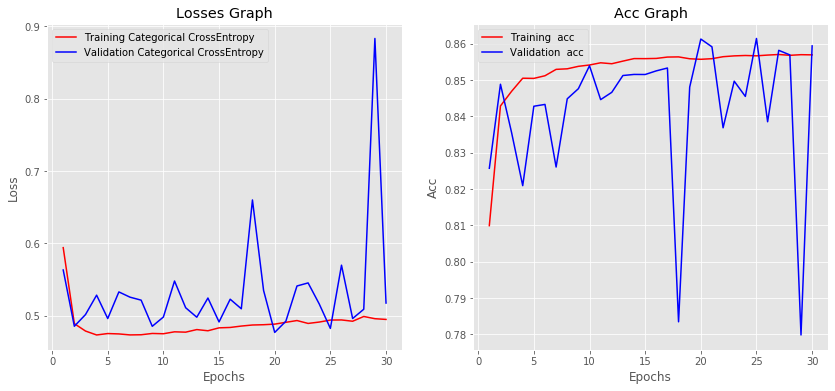

In [0]:
plot_loss(history)
#RMSprob(lr=default)

batch_size : 32


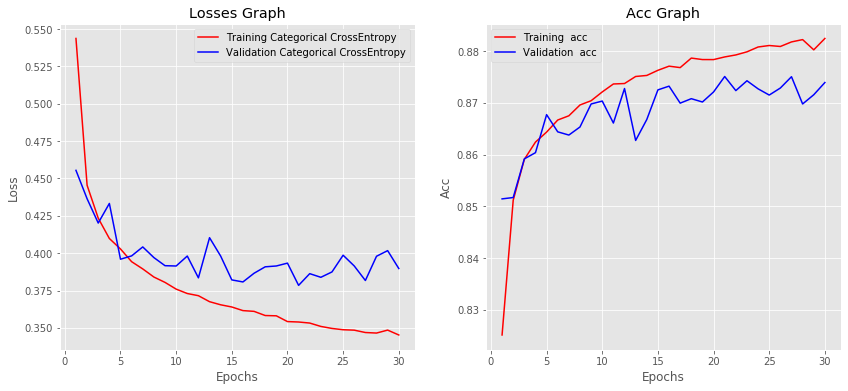

In [0]:
plot_loss(history)
#Adam(lr=default) (lr=0.005 local minimum )

In [0]:
############## After fix model ##############
#Adam 0.0015

In [0]:
print(X_train.shape)
outlier_removed_index=find_outlier(X_train,10)
X_train_out=X_train.loc[outlier_removed_index]
y_train_out=y_train[outlier_removed_index]
print(X_train_out.shape,y_train_out.shape)

(199991, 21)
(199703, 21) (199703,)


In [0]:
X=pd.concat([X_train,X_test],axis=0)

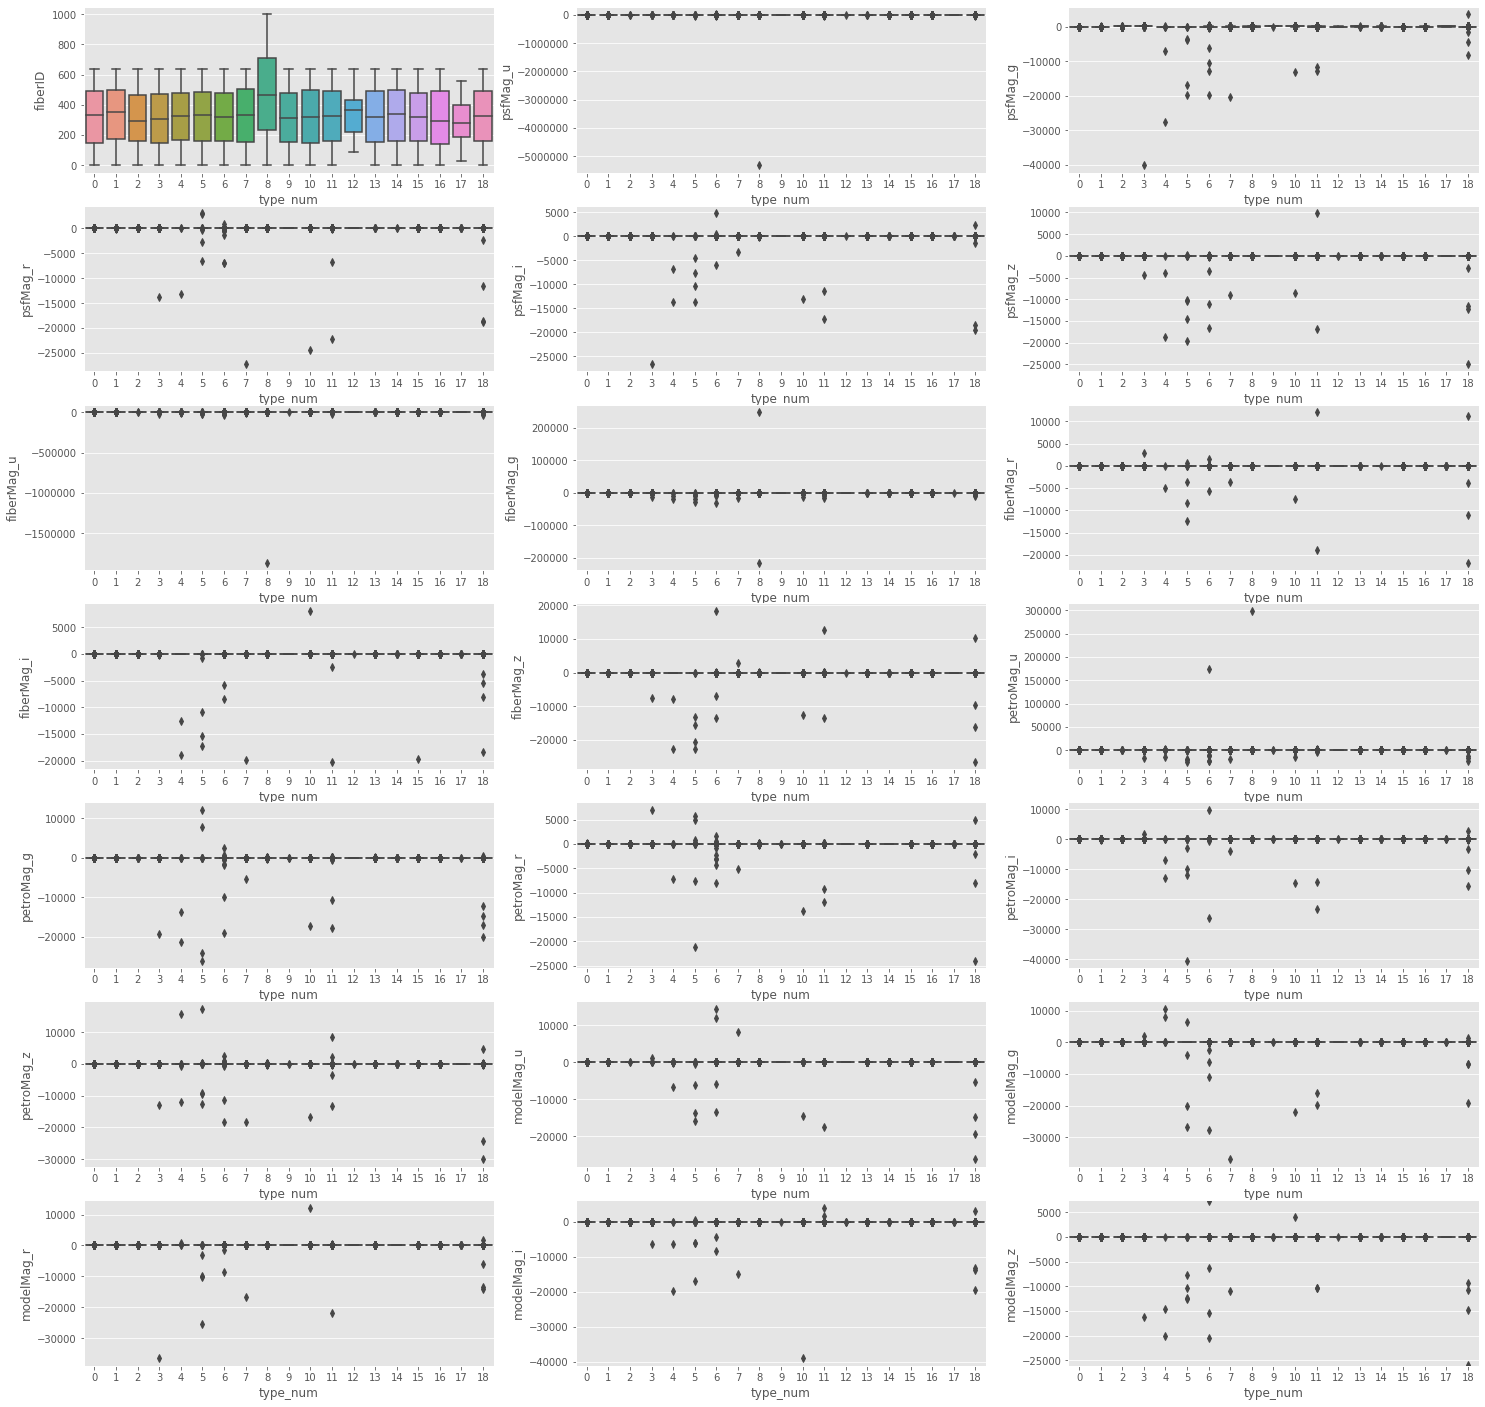

In [54]:
show_boxplot(X_train,y_train)

In [0]:
q_25=np.percentile(X.values,25,axis=0)
q_75=np.percentile(X.values,75,axis=0)
weight=10
iqr=q_75-q_25
w_iqr=iqr*weight
lowest=q_25-w_iqr
highest=q_75+w_iqr
q_15=np.percentile(X.values,15,axis=0)
q_85=np.percentile(X.values,85,axis=0)

real=X[X>lowest].fillna(pd.Series(q_15-w_iqr,index=X.columns))
real=real[real<highest].fillna(pd.Series(q_85+w_iqr,index=real.columns))



In [0]:
X_test_out=real.loc[199991:].copy()

In [0]:
X_train_out=real.loc[:199991].copy()

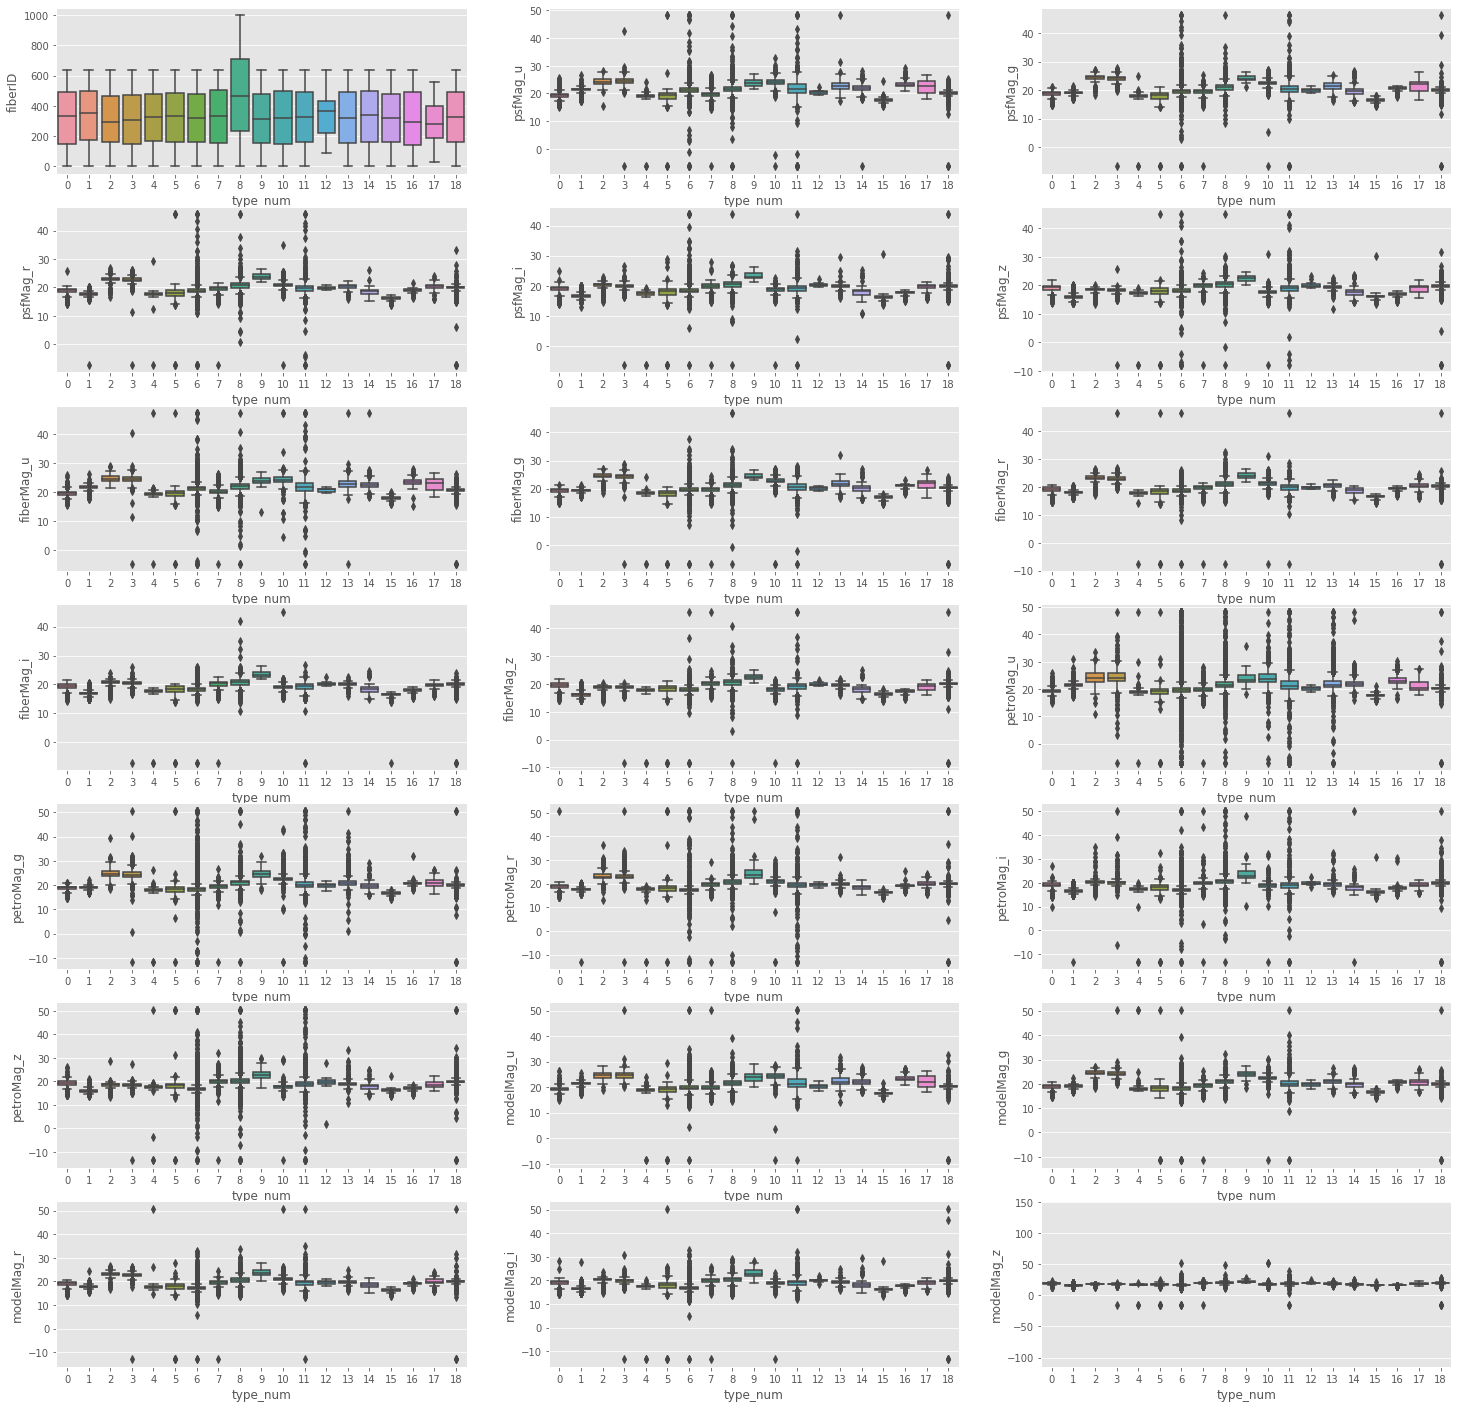

In [71]:
show_boxplot(X_train_out,y_train)

In [0]:
scaler=StandardScaler()
scaler.fit(real)
X_scaled=scaler.transform(real) #real = outlier preprocessed df X

In [0]:
X_scaled_df=pd.DataFrame(X_scaled,columns=real.columns,index=real.index)

In [0]:
X_train_real_scaled=X_scaled_df[:199991].copy()
X_test_real_sclaed=X_scaled_df[199991:].copy()

In [89]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0015),metrics=['acc'])
history=model.fit(X_train_real_scaled,y_train,epochs=45,batch_size=32)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/45





199991/199991 [==============================] - 30s 152us/step - loss: 0.5226 - acc: 0.8296
Epoch 2/45
199991/199991 [==============================] - 20s 100us/step - loss: 0.4321 - acc: 0.8545
Epoch 3/45
199991/199991 [==============================] - 20s 101us/step - loss: 0.4112 - acc: 0.8599
Epoch 4/45
199991/199991 [==============================] - 20s 101us/step - loss: 0.4007 - acc: 0.8626
Epoch 5/45
199991/199991 [==============================] - 20s 99us/step - loss: 0.3918 - acc: 0.8659
Epoch 6/45
199991/199991 [==============================] - 20s 100us/step - loss: 0.3878 - acc: 0.8670
Epoch 7/45
199991/199991 [==============================] - 21s 103us/step - loss: 0.3828 - acc: 0.8679
Epoch 8/45
199991/199991 [==============================] - 21s 103us/step - loss: 0.3794 - acc: 0.8694
Epoch 9/45
199991/199991 [==============================] - 20s 9

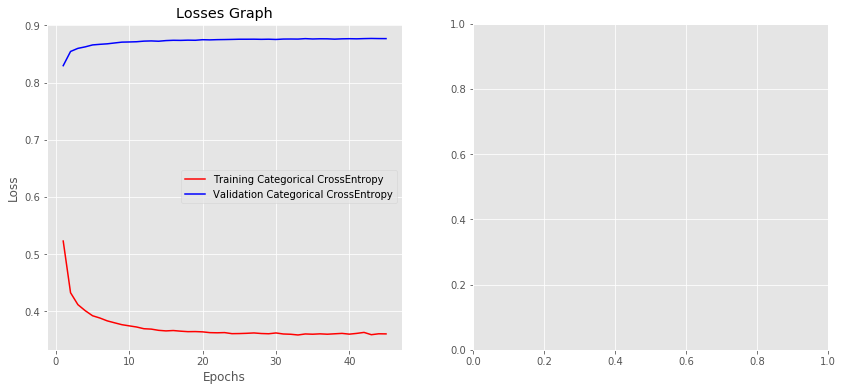

In [91]:
  fig,axes=plt.subplots(1,2,figsize=(14,6))
  train_categorical_crossentropy=history.history['loss'] 
  validation_categorical_crossentropy=history.history['acc']
  xlimit=range(1,len(validation_categorical_crossentropy)+1)
  axes[0].plot(xlimit,train_categorical_crossentropy,'r',label='Training Categorical CrossEntropy')
  axes[0].plot(xlimit,validation_categorical_crossentropy,'b',label='Validation Categorical CrossEntropy')
  axes[0].set_title('Losses Graph')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

In [0]:
pred=model.predict(X_test_real_sclaed)

array([[3.7131067e-21, 5.7921593e-12, 1.7816719e-04, ..., 1.8638401e-10,
        3.8147596e-20, 1.4452372e-09],
       [6.2923997e-16, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        7.3494645e-16, 6.7789797e-12],
       [1.1547376e-10, 2.4900498e-16, 0.0000000e+00, ..., 1.7328181e-33,
        8.1757765e-24, 8.8190551e-35],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.4413493e-07],
       [3.2683936e-05, 1.0123099e-09, 8.8241619e-12, ..., 3.1565593e-15,
        2.3570559e-09, 3.3692072e-06]], dtype=float32)

In [0]:
submission = pd.DataFrame(data=pred, columns=sample_submission.columns, index=sample_submission.index)
submission.to_csv('submission.csv', index=True)